## 1. Setup and Imports

In [5]:
import sys
import os

# Ensure project root (with 'automl' package) is on sys.path
try:
    def find_project_root(start_path: str, max_up: int = 4):
        cur = os.path.abspath(start_path)
        for _ in range(max_up + 1):
            if os.path.exists(os.path.join(cur, 'automl', '__init__.py')):
                return cur
            parent = os.path.dirname(cur)
            if parent == cur:
                break
            cur = parent
        return None

    start = os.getcwd()
    project_root = find_project_root(start)
    if project_root and project_root not in sys.path:
        sys.path.insert(0, project_root)
except Exception:
    pass

try:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from datetime import datetime, timedelta

    # Import AutoML modules
    from automl.pipeline import run_pipeline
    from automl.preprocessing import preprocess_data
    from automl.model_trainer import train_models, train_tabular_models

    # Verify updated function signature (ensures fresh modules loaded)
    import inspect
    sig = inspect.signature(train_models)
    if 'task_type' not in sig.parameters:
        raise ImportError("Outdated 'train_models' signature (missing 'task_type') — kernel likely not restarted.")

    print("=" * 70)
    print("✅ Imports successful! Kernel is fresh.")
    print("Project root:", project_root or os.getcwd())
    print("=" * 70)
    SETUP_OK = True
except Exception as e:
    print("=" * 70)
    print("⚠️  KERNEL RESTART OR PATH FIX REQUIRED")
    print("=" * 70)
    if not project_root:
        print("\nCould not locate project root containing 'automl'.")
        print("If running from the Notebooks folder, the project root is one level up.")
        print("Try setting the working directory to the project root or restart the kernel.")
    else:
        print("\nThe AutoML modules were updated with major fixes.")
        print("Please restart the Jupyter kernel and run this cell again.")
    print("\nDetails:", str(e))
    print("=" * 70)
    raise RuntimeError("Environment not ready — please restart the kernel or open the notebook with working dir at project root.")

✅ Imports successful! Kernel is fresh.
Project root: c:\Users\Sajjad Ur Rehman\Desktop\AutoML_System


## 2. Generate Synthetic Time Series Data

We'll create a synthetic time series with trend, seasonality, and noise.

In [6]:
# Generate synthetic time series data
np.random.seed(42)
n_points = 500

# Create time index
start_date = datetime(2022, 1, 1)
dates = [start_date + timedelta(days=i) for i in range(n_points)]

# Create time series components
t = np.arange(n_points)
trend = 0.05 * t + 10  # Linear trend
seasonality = 5 * np.sin(2 * np.pi * t / 30)  # 30-day cycle
noise = np.random.normal(0, 1, n_points)

# Combine components
values = trend + seasonality + noise

# Create DataFrame
df = pd.DataFrame({
    'date': dates,
    'value': values,
    'time_index': t
})

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nFirst few rows:")
df.head(10)

Dataset shape: (500, 3)
Date range: 2022-01-01 00:00:00 to 2023-05-15 00:00:00

First few rows:


,date,value,time_index
0,2022-01-01,10.496714,0
1,2022-01-02,10.951294,1
2,2022-01-03,12.781372,2
3,2022-01-04,14.611956,3
4,2022-01-05,13.681571,4
5,2022-01-06,14.345990,5
6,2022-01-07,16.634495,6
7,2022-01-08,16.090044,7
8,2022-01-09,14.903135,8
9,2022-01-10,15.747843,9


## 3. Visualize Time Series

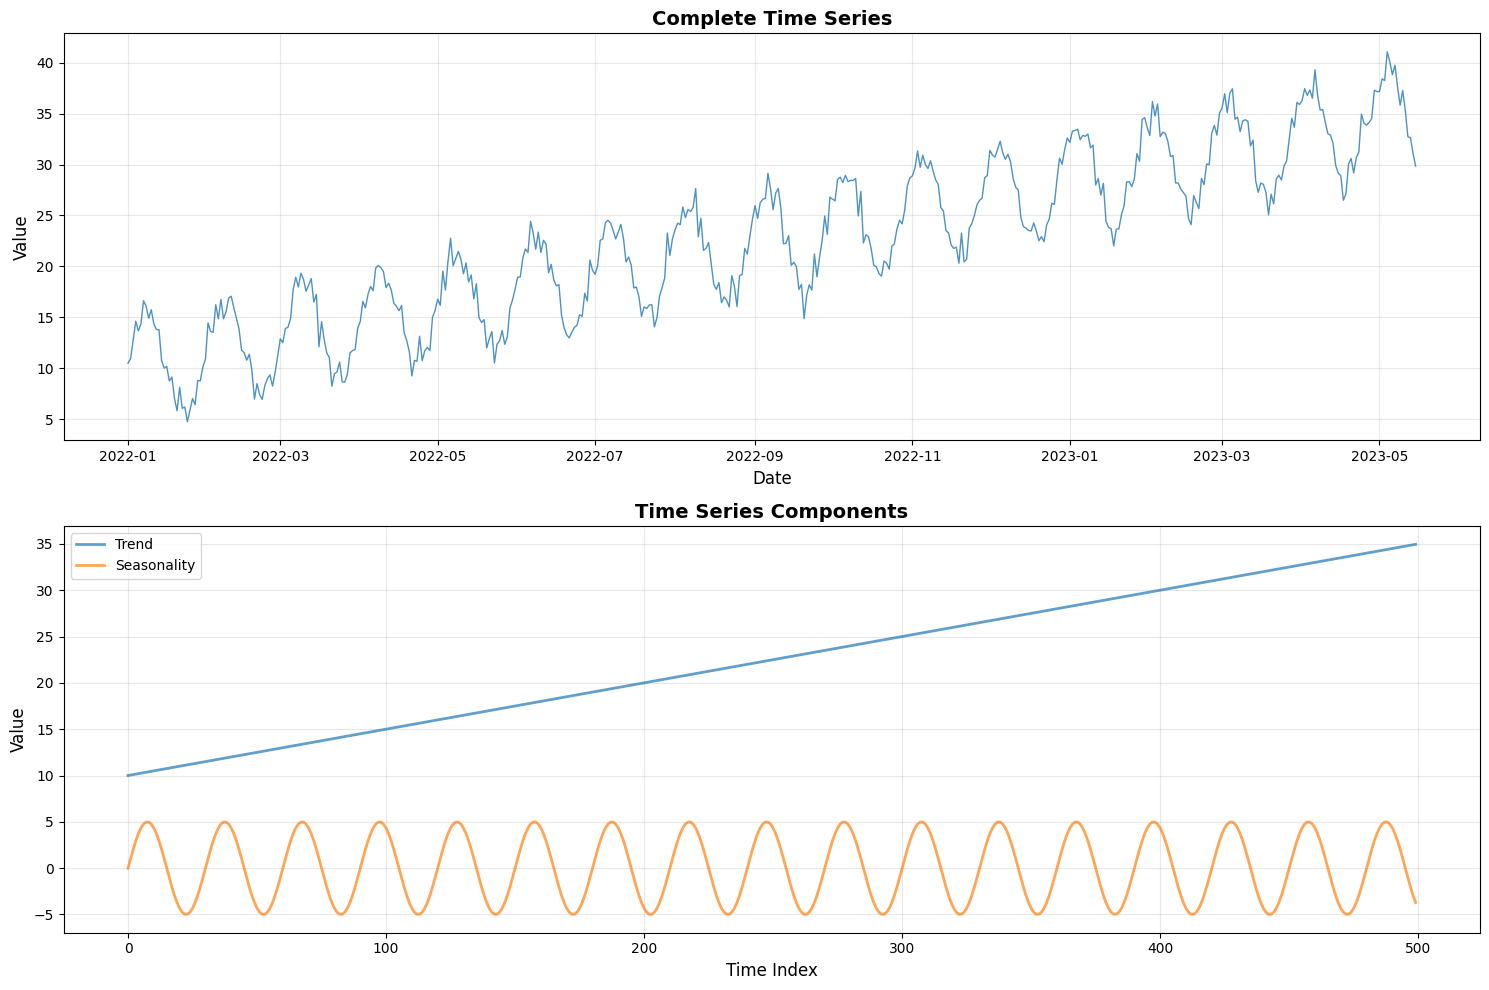

In [7]:
# Plot full time series
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Full series
axes[0].plot(df['date'], df['value'], linewidth=1, alpha=0.8)
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Value', fontsize=12)
axes[0].set_title('Complete Time Series', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Components visualization
axes[1].plot(t, trend, label='Trend', linewidth=2, alpha=0.7)
axes[1].plot(t, seasonality, label='Seasonality', linewidth=2, alpha=0.7)
axes[1].set_xlabel('Time Index', fontsize=12)
axes[1].set_ylabel('Value', fontsize=12)
axes[1].set_title('Time Series Components', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

📊 Time Series Statistics:
count    500.000000
mean      22.557526
std        8.098241
min        4.752642
25%       16.226005
50%       22.630917
75%       28.633429
max       41.059751
Name: value, dtype: float64


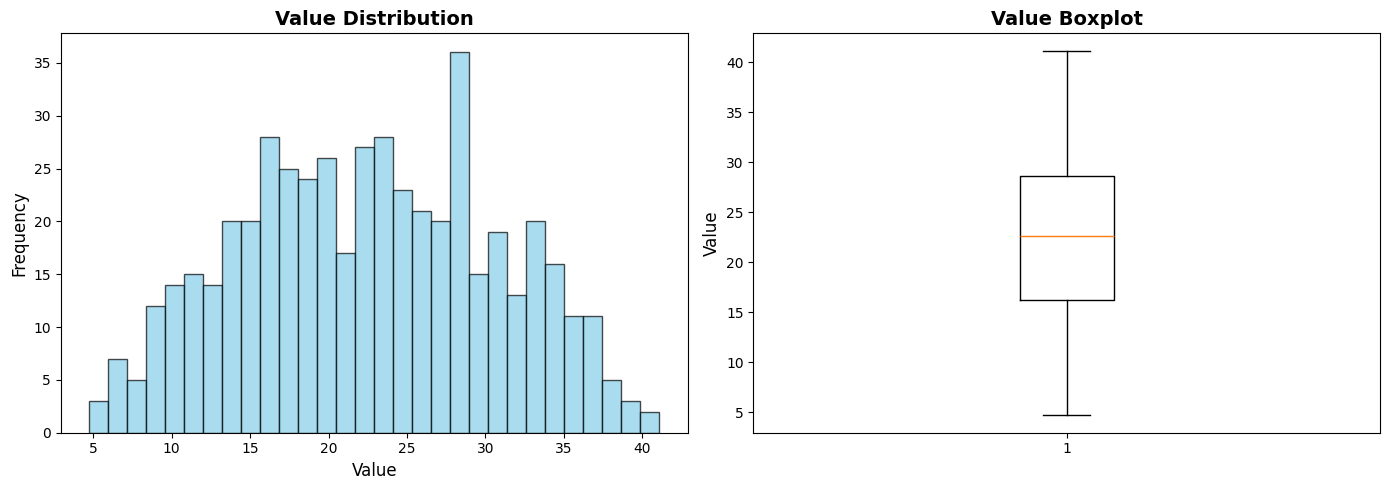

In [8]:
# Statistical summary
print("📊 Time Series Statistics:")
print(df['value'].describe())

# Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['value'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Value', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Value Distribution', fontsize=14, fontweight='bold')

axes[1].boxplot(df['value'], vert=True)
axes[1].set_ylabel('Value', fontsize=12)
axes[1].set_title('Value Boxplot', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Prepare Data for AutoML

For time series, we'll create lag features manually or let the pipeline handle it.

In [9]:
# Create additional features
df['day_of_week'] = pd.to_datetime(df['date']).dt.dayofweek
df['month'] = pd.to_datetime(df['date']).dt.month
df['day_of_year'] = pd.to_datetime(df['date']).dt.dayofyear

# The pipeline will create lag features, but we'll keep our time index
df_model = df[['time_index', 'day_of_week', 'month', 'day_of_year', 'value']].copy()

print("Prepared dataset shape:", df_model.shape)
print("\nFeatures:", list(df_model.columns[:-1]))
print("Target: value")
df_model.head()

Prepared dataset shape: (500, 5)

Features: ['time_index', 'day_of_week', 'month', 'day_of_year']
Target: value


,time_index,day_of_week,month,day_of_year,value
0,0,5,1,1,10.496714
1,1,6,1,2,10.951294
2,2,0,1,3,12.781372
3,3,1,1,4,14.611956
4,4,2,1,5,13.681571


## 5. Run AutoML Pipeline

**⚠️ IMPORTANT:** Before running this cell, please restart the Jupyter kernel to reload the fixed `tabular_preprocessing` module:
- Press **Ctrl+Shift+P** and type "Restart Kernel"
- Or click the restart button in the toolbar

The pipeline will:
1. Preprocess the data (scaling, encoding, splitting)
2. Train multiple regression models
3. Evaluate forecasting performance
4. Return the best performing model

**Note:** The preprocessing now correctly handles regression tasks by NOT using stratification (which is only for classification).


In [10]:
print("🚀 Running AutoML pipeline on time series data...\n")

# Run pipeline
results = run_pipeline(
    dataset=df_model,
    target_column='value',
    task_type='regression',
    feature_selection_enabled=True,
    hyperparameter_tuning_enabled=False  # Skip for speed
)

print("\n" + "="*70)
print("✅ Pipeline completed successfully!")
print("="*70)

2025-12-19 03:25:21,240 - automl.preprocessing - INFO - ======================================================================
2025-12-19 03:25:21,241 - automl.preprocessing - INFO - 🚀 AUTOML PREPROCESSING DISPATCHER
2025-12-19 03:25:21,242 - automl.preprocessing - INFO - ======================================================================
2025-12-19 03:25:21,243 - automl.preprocessing - INFO - 📌 Data type: tabular
2025-12-19 03:25:21,244 - automl.preprocessing - INFO - 📊 Routing to: tabular_preprocessing.preprocess_tabular()
2025-12-19 03:25:21,247 - automl.preprocessing - INFO - ======================================================================
2025-12-19 03:25:21,248 - automl.tabular_preprocessing - INFO - ============================================================
2025-12-19 03:25:21,249 - automl.tabular_preprocessing - INFO - Starting tabular data preprocessing...
2025-12-19 03:25:21,251 - automl.tabular_preprocessing - INFO - ===============================================

🚀 Running AutoML pipeline on time series data...

==== AutoML Pipeline: Start ====
Detected data type: tabular
Preprocessing data...
Running feature selection...
Initial features: 4
Selected features: 2
Applying selected indices to train/val/test splits...
Training baseline models...
Training tabular model: LinearRegression
Training tabular model: DecisionTreeRegressor
Training tabular model: RandomForestRegressor
Training tabular model: GradientBoostingRegressor
Training tabular model: KNeighborsRegressor
Evaluating models...
Evaluating model: linear_regression
Evaluating model: decision_tree
Evaluating model: random_forest
Evaluating model: gradient_boosting
Evaluating model: knn
Selecting best model...
Model linear_regression: RMSE=8.1327, R2=0.0649
Model decision_tree: RMSE=13.2048, R2=-1.4652
Model random_forest: RMSE=10.8501, R2=-0.6644
Model gradient_boosting: RMSE=9.2745, R2=-0.2161
Model knn: RMSE=8.1894, R2=0.0518
Selected best model: linear_regression. Reason: Lowest RMSE (8

## 6. Analyze Results

In [12]:
# Best model
best_model_info = results.get('best_model')
best_model_name = None
best_model_obj = None

# Extract name/object from various possible shapes
if isinstance(best_model_info, dict):
    best_model_name = (
        best_model_info.get('name')
        or best_model_info.get('Model')
        or best_model_info.get('model_name')
    )
    best_model_obj = (
        best_model_info.get('model')
        or best_model_info.get('estimator')
        or best_model_info.get('object')
        or best_model_info.get('model_obj')
    )
else:
    # If best_model is directly the estimator object
    best_model_obj = best_model_info

# Fallback: infer best model name from evaluation results
evaluation_results = results.get('evaluation_results', {})
if not best_model_name and isinstance(evaluation_results, dict) and evaluation_results:
    import numpy as np
    def score_key(item):
        name, data = item
        metrics = data.get('metrics', {})
        rmse = metrics.get('rmse')
        r2 = metrics.get('r2')
        # Prefer lowest RMSE; tie-breaker is highest R²
        return (rmse if rmse is not None else np.inf, -(r2 if r2 is not None else -np.inf))
    try:
        best_model_name = sorted(evaluation_results.items(), key=score_key)[0][0]
    except Exception:
        best_model_name = next(iter(evaluation_results))

# Try retrieving the trained estimator from results if missing
if best_model_obj is None and best_model_name:
    trained = results.get('trained_models', {})
    if isinstance(trained, dict):
        best_model_obj = trained.get(best_model_name)

print(f"🏆 Best Model: {best_model_name or 'Unknown'}")
print("\nModel Details:")
if best_model_obj is not None:
    print(best_model_obj)
else:
    print("Model object not available in results. Proceeding with metrics only.")

🏆 Best Model: linear_regression

Model Details:
LinearRegression()


In [13]:
# Model comparison
print("📈 Model Performance Comparison:\n")
evaluation_results = results['evaluation_results']

model_scores = []
for model_name, eval_data in evaluation_results.items():
    metrics = eval_data.get('metrics', {})
    model_scores.append({
        'Model': model_name,
        'RMSE': metrics.get('rmse', 0),
        'MAE': metrics.get('mae', 0),
        'R²': metrics.get('r2', 0),
        'MSE': metrics.get('mse', 0)
    })

scores_df = pd.DataFrame(model_scores)
scores_df = scores_df.sort_values('RMSE', ascending=True)
print(scores_df.to_string(index=False))

📈 Model Performance Comparison:

            Model      RMSE       MAE        R²        MSE
linear_regression  8.132703  6.956669  0.064888  66.140863
              knn  8.189386  6.599061  0.051808  67.066040
gradient_boosting  9.274469  7.570334 -0.216107  86.015772
    random_forest 10.850142  8.569465 -0.664426 117.725576
    decision_tree 13.204788 10.271315 -1.465224 174.366417


## 7. Visualize Performance

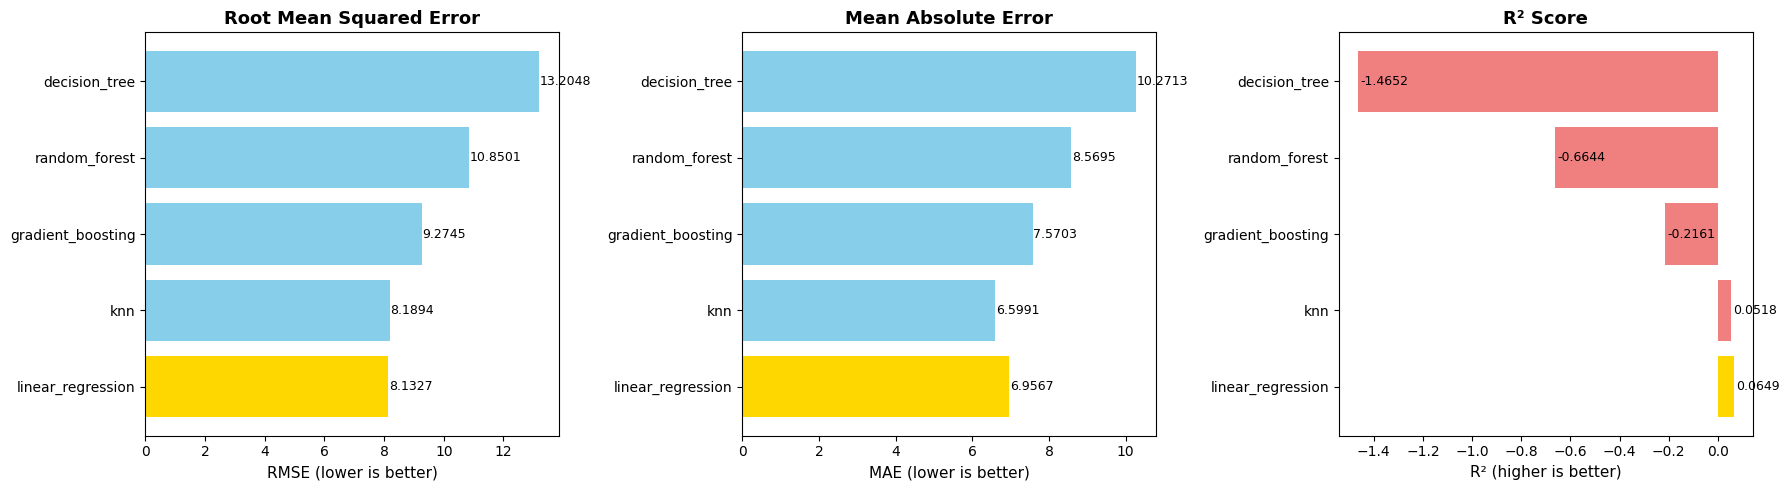

In [14]:
# Performance metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE
colors_rmse = ['gold' if model == best_model_name else 'skyblue' for model in scores_df['Model']]
axes[0].barh(scores_df['Model'], scores_df['RMSE'], color=colors_rmse)
axes[0].set_xlabel('RMSE (lower is better)', fontsize=11)
axes[0].set_title('Root Mean Squared Error', fontsize=13, fontweight='bold')
for i, v in enumerate(scores_df['RMSE']):
    axes[0].text(v + 0.02, i, f'{v:.4f}', va='center', fontsize=9)

# MAE
axes[1].barh(scores_df['Model'], scores_df['MAE'], color=colors_rmse)
axes[1].set_xlabel('MAE (lower is better)', fontsize=11)
axes[1].set_title('Mean Absolute Error', fontsize=13, fontweight='bold')
for i, v in enumerate(scores_df['MAE']):
    axes[1].text(v + 0.02, i, f'{v:.4f}', va='center', fontsize=9)

# R²
colors_r2 = ['gold' if model == best_model_name else 'lightcoral' for model in scores_df['Model']]
axes[2].barh(scores_df['Model'], scores_df['R²'], color=colors_r2)
axes[2].set_xlabel('R² (higher is better)', fontsize=11)
axes[2].set_title('R² Score', fontsize=13, fontweight='bold')
for i, v in enumerate(scores_df['R²']):
    axes[2].text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 8. Predictions vs Actual Values

In [15]:
# Get predictions from best model
best_eval = evaluation_results[best_model_name]
if 'y_true' in best_eval and 'y_pred' in best_eval:
    y_true = best_eval['y_true']
    y_pred = best_eval['y_pred']
    
    # Plot predictions vs actual
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Time series plot
    test_size = len(y_true)
    test_indices = range(len(df) - test_size, len(df))
    
    axes[0].plot(test_indices, y_true, label='Actual', linewidth=2, alpha=0.7)
    axes[0].plot(test_indices, y_pred, label='Predicted', linewidth=2, alpha=0.7)
    axes[0].set_xlabel('Time Index', fontsize=12)
    axes[0].set_ylabel('Value', fontsize=12)
    axes[0].set_title(f'Predictions vs Actual - {best_model_name}', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Scatter plot
    axes[1].scatter(y_true, y_pred, alpha=0.5, s=30)
    axes[1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
                 'r--', lw=2, label='Perfect Prediction')
    axes[1].set_xlabel('Actual Values', fontsize=12)
    axes[1].set_ylabel('Predicted Values', fontsize=12)
    axes[1].set_title('Actual vs Predicted Scatter', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Residuals
    residuals = y_true - y_pred
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Residual plot
    axes[0].scatter(y_pred, residuals, alpha=0.5, s=30)
    axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[0].set_xlabel('Predicted Values', fontsize=12)
    axes[0].set_ylabel('Residuals', fontsize=12)
    axes[0].set_title('Residual Plot', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Residual distribution
    axes[1].hist(residuals, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[1].set_xlabel('Residuals', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].set_title('Residual Distribution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Residual Statistics:")
    print(f"Mean: {residuals.mean():.6f}")
    print(f"Std Dev: {residuals.std():.6f}")
    print(f"Min: {residuals.min():.6f}")
    print(f"Max: {residuals.max():.6f}")

## 9. Feature Importance

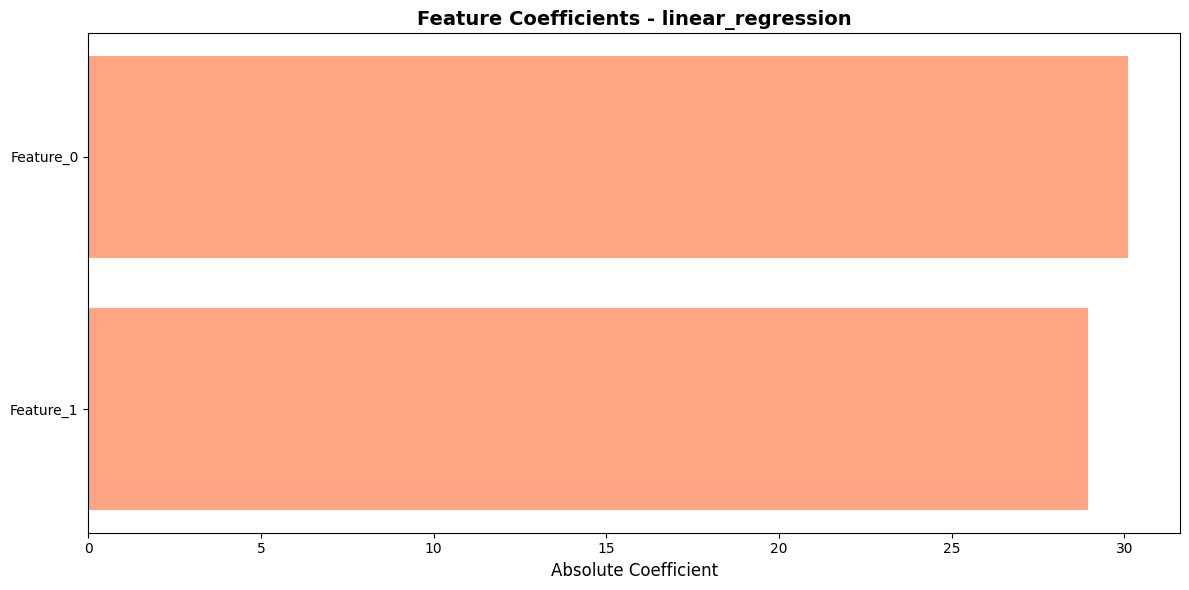


📊 Feature Coefficients:
  Feature  Coefficient
Feature_0    30.107652
Feature_1    28.936931


In [16]:
# Feature importance (if available)
if hasattr(best_model_obj, 'feature_importances_'):
    feature_names = results.get('selected_features', [])
    if not feature_names:
        feature_names = [f'Feature_{i}' for i in range(len(best_model_obj.feature_importances_))]
    
    importances = best_model_obj.feature_importances_
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='teal', alpha=0.7)
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Feature Importance Rankings:")
    print(importance_df.to_string(index=False))
elif hasattr(best_model_obj, 'coef_'):
    # For linear models
    feature_names = results.get('selected_features', [])
    if not feature_names:
        feature_names = [f'Feature_{i}' for i in range(len(best_model_obj.coef_))]
    
    coefs = np.abs(best_model_obj.coef_)
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefs
    }).sort_values('Coefficient', ascending=False)
    
    plt.figure(figsize=(12, 6))
    plt.barh(importance_df['Feature'], importance_df['Coefficient'], color='coral', alpha=0.7)
    plt.xlabel('Absolute Coefficient', fontsize=12)
    plt.title(f'Feature Coefficients - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Feature Coefficients:")
    print(importance_df.to_string(index=False))
else:
    print(f"ℹ️ Feature importance not available for {best_model_name}")

## 10. Try with Different Parameters

2025-12-19 03:28:40,881 - automl.preprocessing - INFO - ======================================================================
2025-12-19 03:28:40,882 - automl.preprocessing - INFO - 🚀 AUTOML PREPROCESSING DISPATCHER
2025-12-19 03:28:40,883 - automl.preprocessing - INFO - ======================================================================
2025-12-19 03:28:40,885 - automl.preprocessing - INFO - 📌 Data type: tabular
2025-12-19 03:28:40,887 - automl.preprocessing - INFO - 📊 Routing to: tabular_preprocessing.preprocess_tabular()
2025-12-19 03:28:40,888 - automl.preprocessing - INFO - ======================================================================
2025-12-19 03:28:40,891 - automl.tabular_preprocessing - INFO - ============================================================
2025-12-19 03:28:40,893 - automl.tabular_preprocessing - INFO - Starting tabular data preprocessing...
2025-12-19 03:28:40,895 - automl.tabular_preprocessing - INFO - ===============================================

🔬 Experimenting with different configurations...

Testing Minimal...
==== AutoML Pipeline: Start ====
Detected data type: tabular
Preprocessing data...
Training baseline models...
Training tabular model: LinearRegression
Training tabular model: DecisionTreeRegressor
Training tabular model: RandomForestRegressor
Training tabular model: GradientBoostingRegressor
Training tabular model: KNeighborsRegressor
Evaluating models...
Evaluating model: linear_regression
Evaluating model: decision_tree
Evaluating model: random_forest


2025-12-19 03:28:41,650 - automl.preprocessing - INFO - ======================================================================
2025-12-19 03:28:41,652 - automl.preprocessing - INFO - 🚀 AUTOML PREPROCESSING DISPATCHER
2025-12-19 03:28:41,655 - automl.preprocessing - INFO - ======================================================================
2025-12-19 03:28:41,656 - automl.preprocessing - INFO - 📌 Data type: tabular
2025-12-19 03:28:41,658 - automl.preprocessing - INFO - 📊 Routing to: tabular_preprocessing.preprocess_tabular()
2025-12-19 03:28:41,659 - automl.preprocessing - INFO - ======================================================================
2025-12-19 03:28:41,661 - automl.tabular_preprocessing - INFO - ============================================================
2025-12-19 03:28:41,663 - automl.tabular_preprocessing - INFO - Starting tabular data preprocessing...
2025-12-19 03:28:41,665 - automl.tabular_preprocessing - INFO - ===============================================

Evaluating model: gradient_boosting
Evaluating model: knn
Selecting best model...
Model linear_regression: RMSE=3.1927, R2=0.8559
Model decision_tree: RMSE=1.7448, R2=0.9570
Model random_forest: RMSE=1.2369, R2=0.9784
Model gradient_boosting: RMSE=1.9457, R2=0.9465
Model knn: RMSE=4.3383, R2=0.7339
Selected best model: random_forest. Reason: Lowest RMSE (1.2369); tie-broken by highest R² (0.9784).
==== AutoML Pipeline: Done ====
Testing With FS...
==== AutoML Pipeline: Start ====
Detected data type: tabular
Preprocessing data...
Running feature selection...
Initial features: 4
Selected features: 2
Applying selected indices to train/val/test splits...
Training baseline models...
Training tabular model: LinearRegression
Training tabular model: DecisionTreeRegressor
Training tabular model: RandomForestRegressor


2025-12-19 03:28:43,108 - automl.preprocessing - INFO - ======================================================================
2025-12-19 03:28:43,110 - automl.preprocessing - INFO - 🚀 AUTOML PREPROCESSING DISPATCHER
2025-12-19 03:28:43,111 - automl.preprocessing - INFO - ======================================================================
2025-12-19 03:28:43,112 - automl.preprocessing - INFO - 📌 Data type: tabular
2025-12-19 03:28:43,113 - automl.preprocessing - INFO - 📊 Routing to: tabular_preprocessing.preprocess_tabular()
2025-12-19 03:28:43,114 - automl.preprocessing - INFO - ======================================================================
2025-12-19 03:28:43,114 - automl.tabular_preprocessing - INFO - ============================================================
2025-12-19 03:28:43,115 - automl.tabular_preprocessing - INFO - Starting tabular data preprocessing...
2025-12-19 03:28:43,116 - automl.tabular_preprocessing - INFO - ===============================================

Training tabular model: GradientBoostingRegressor
Training tabular model: KNeighborsRegressor
Evaluating models...
Evaluating model: linear_regression
Evaluating model: decision_tree
Evaluating model: random_forest
Evaluating model: gradient_boosting
Evaluating model: knn
Selecting best model...
Model linear_regression: RMSE=8.1327, R2=0.0649
Model decision_tree: RMSE=13.2048, R2=-1.4652
Model random_forest: RMSE=10.8501, R2=-0.6644
Model gradient_boosting: RMSE=9.2745, R2=-0.2161
Model knn: RMSE=8.1894, R2=0.0518
Selected best model: linear_regression. Reason: Lowest RMSE (8.1327); tie-broken by highest R² (0.0649).
==== AutoML Pipeline: Done ====
Testing Full Pipeline...
==== AutoML Pipeline: Start ====
Detected data type: tabular
Preprocessing data...


2025-12-19 03:28:43,137 - automl.tabular_preprocessing - INFO -   • Val:   (50, 4)
2025-12-19 03:28:43,138 - automl.tabular_preprocessing - INFO -   • Test:  (100, 4)
2025-12-19 03:28:43,138 - automl.tabular_preprocessing - INFO - ============================================================


Running feature selection...
Initial features: 4
Selected features: 2
Applying selected indices to train/val/test splits...
Training baseline models...
Training tabular model: LinearRegression
Training tabular model: DecisionTreeRegressor
Training tabular model: RandomForestRegressor
Training tabular model: GradientBoostingRegressor
Training tabular model: KNeighborsRegressor
Evaluating models...
Evaluating model: linear_regression
Evaluating model: decision_tree
Evaluating model: random_forest
Evaluating model: gradient_boosting
Evaluating model: knn
Selecting best model...
Model linear_regression: RMSE=8.1327, R2=0.0649
Model decision_tree: RMSE=13.2048, R2=-1.4652
Model random_forest: RMSE=10.8501, R2=-0.6644
Model gradient_boosting: RMSE=9.2745, R2=-0.2161
Model knn: RMSE=8.1894, R2=0.0518
Selected best model: linear_regression. Reason: Lowest RMSE (8.1327); tie-broken by highest R² (0.0649).
Tuning hyperparameters for selected model...
Hyperparameter tuning method: grid
Best param

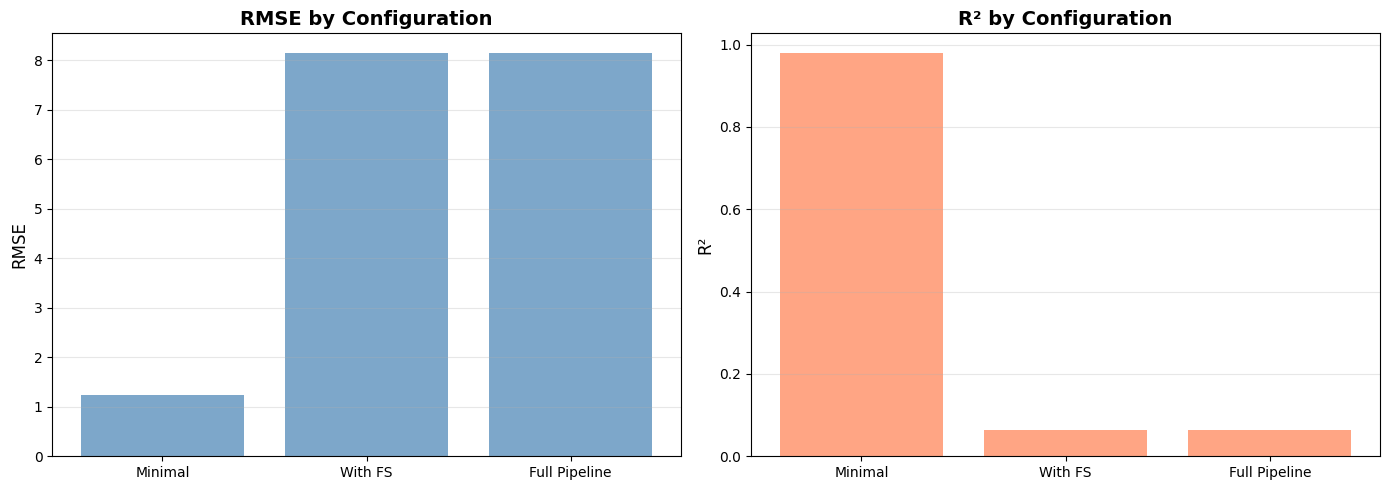

In [17]:
# Experiment with different configurations
print("🔬 Experimenting with different configurations...\n")

experiment_results = []

configs = [
    {'name': 'Minimal', 'feature_selection': False, 'tuning': False},
    {'name': 'With FS', 'feature_selection': True, 'tuning': False},
    {'name': 'Full Pipeline', 'feature_selection': True, 'tuning': True}
]

for config in configs:
    config_name = config['name']
    print(f"Testing {config_name}...")
    
    results_exp = run_pipeline(
        dataset=df_model,
        target_column='value',
        task_type='regression',
        feature_selection_enabled=config['feature_selection'],
        hyperparameter_tuning_enabled=config['tuning']
    )
    
    best_name = results_exp['best_model']['name']
    best_metrics = results_exp['evaluation_results'][best_name]['metrics']
    
    experiment_results.append({
        'Configuration': config_name,
        'Feature Selection': config['feature_selection'],
        'Hyperparameter Tuning': config['tuning'],
        'Model': best_name,
        'RMSE': best_metrics.get('rmse', 0),
        'R²': best_metrics.get('r2', 0)
    })

# Compare results
exp_df = pd.DataFrame(experiment_results)
print("\n📊 Configuration Comparison Results:")
print(exp_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(exp_df['Configuration'], exp_df['RMSE'], alpha=0.7, color='steelblue')
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].set_title('RMSE by Configuration', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(exp_df['Configuration'], exp_df['R²'], alpha=0.7, color='coral')
axes[1].set_ylabel('R²', fontsize=12)
axes[1].set_title('R² by Configuration', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 11. Summary

This notebook demonstrated:
- ✅ Creating and analyzing time series data
- ✅ Automatic lag feature creation
- ✅ Time series preprocessing and scaling
- ✅ Multiple regression model training
- ✅ Forecasting evaluation (RMSE, MAE, R²)
- ✅ Prediction visualization and residual analysis
- ✅ Hyperparameter experimentation

**Next Steps:**
- Try with real-world time series (stock prices, weather, sales)
- Experiment with different lag configurations
- Add external features (holidays, events)
- Compare with specialized time series models (ARIMA, Prophet)